# Classification with Naive Bayes

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 1

Name: <i>**Yifei zhang**</i>

Student ID: <i>**u6001933**</i>

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 19|
|Weight|19% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument. Typeset all formulas in $\LaTeX$.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 20%. No assignments shall be accepted if it is later than 5 days. | 
| Cooperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |
| Solution | To be presented in the tutorials. |

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$
$\newcommand{\B}[1]{\mathbf{#1}}$
$\newcommand{\Bphi}{\boldsymbol{\mathsf{\phi}}}$
$\newcommand{\BPhi}{\boldsymbol{\Phi}}$
$\newcommand{\Cond}{\,|\,}$
$\newcommand{\DNorm}[3]{\mathcal{N}(#1\Cond#2, #3)}$
$\newcommand{\DUniform}[3]{\mathcal{U}(#1 \Cond #2, #3)}$
$\newcommand{\Ex}[2][]{\mathbb{E}_{#1} \left[ #2 \right]}$
$\newcommand{\var}[1]{\operatorname{var}[#1]}$
$\newcommand{\cov}[1]{\operatorname{cov}[#1]}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\DeclareMathOperator*{\argmax}{arg\,max}$

Setting up the environment (Please evaluate this cell to activate the $\LaTeX$ macros.)

In [1]:
import csv, scipy, scipy.stats, collections, itertools
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
a = np.array([1,2,3,3,4,5,6])
b= np.median(a)
print ((a>b).astype(float).reshape(-1,1))
def f(x):
    return x+1
preprocessor = collections.defaultdict(lambda: f)
preprocessor["a"] =1
preprocessor["b"]

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]]


<function __main__.f>

## The data set


The data set contains census information. Our task is to predict whether an indivual earns more than some amount.

Please download the following data:
* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

Read and preprocess the data.

In [2]:
raw_data = np.genfromtxt("adult.data", dtype=str, delimiter=',', autostrip=True)

# targets
target = ">50K"
target_column = raw_data[:,-1]
Y = (target_column == target).reshape(-1,1)
assert any(Y) and any(~Y), set(target_column)

features = [
    'age', 'workclass', 'fnlwgt','education', 'education_num', 'marital_status', 
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
    'hours_per_week', 'native_country'
]

raw_features = raw_data[:,:-1] # drop the target
assert raw_features.shape[1] == len(features)


def preprocess_continuous(column):
    # convert continuous variables stored as strings to binary by comparing with the median
    float_column = column.astype(float)
    return (float_column > np.median(float_column)).astype(float).reshape(-1,1)


def preprocess_categorical(column):
    # convert categorical variables to indicator vectors
    values = sorted(set(column))
    if len(values) == 2:
        values = values[:1]
    return np.hstack([column.reshape(-1,1)==v for v in values]).astype(float)


preprocessor = collections.defaultdict(lambda: preprocess_categorical)
preprocessor.update(dict(
    age=preprocess_continuous, 
    fnlwgt=preprocess_continuous, 
    education_num=preprocess_continuous,
    capital_gain=preprocess_continuous, 
    capital_loss=preprocess_continuous, 
    hours_per_week=preprocess_continuous,
))

# apply appropriate preprocessor to each column of raw_features
X_list = [preprocessor[feature](raw_features[:,features.index(feature)]) for feature in features]
for feature, X in zip(features, X_list):
    assert X.shape[0] == raw_features.shape[0]
    print(X.shape[1], '\t', feature)
    
make_feature_names = lambda feature, dimension: ['%s_%.2i' % (feature, i) for i in range(dimension)]
binary_feature_names_list = [make_feature_names(feature, X.shape[1]) for feature, X in zip(features, X_list)]
binary_feature_names = list(itertools.chain(*binary_feature_names_list))

X = np.hstack(X_list)
assert set(X.flatten()) == {0.0, 1.0}
assert len(binary_feature_names) == X.shape[1]

1 	 age
9 	 workclass
1 	 fnlwgt
16 	 education
1 	 education_num
7 	 marital_status
15 	 occupation
6 	 relationship
5 	 race
1 	 sex
1 	 capital_gain
1 	 capital_loss
1 	 hours_per_week
42 	 native_country


Plot the data.


X.shape 	 (32561, 107)
Y.shape 	 (32561, 1)

mean(Y) 0.240809557446


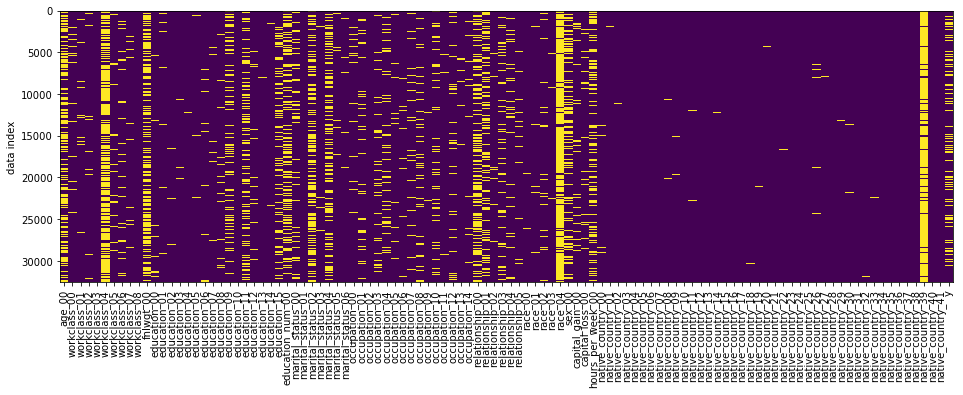

In [3]:
print('')
print('X.shape', '\t', X.shape)
print('Y.shape', '\t', Y.shape)
print()
print('mean(Y)', np.mean(Y))

figure = lambda : plt.figure(figsize=(16,5))
figure()
plt.imshow(np.hstack((X,Y)))
plt.axis('auto')
plt.ylabel('data index');
plt.gca().set_xticks(list(range(X.shape[1]+1)))
plt.gca().set_xticklabels(binary_feature_names+['y'], rotation='vertical')

ntrain = 1200
ishuffle = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(ishuffle)
itrain = ishuffle[slice(0,ntrain)]
itest = ishuffle[slice(ntrain,None)]
X_train, Y_train = X[itrain,:], Y[itrain,:]
X_test, Y_test = X[itest,:], Y[itest,:]

## (3 points) 1A: Naive Bayes: Maximum Likelihood (m.l.)
Assume we have dataset $\mathcal{D}=\left\{(\mathbf{x}_i,y_i\right)\}_{i=1,2,\ldots,n}$ where $\mathbf{x}_i\in\{0,1\}^d$, $y_i\in\{0,1\}$, $n$ is the number of data points and $d$ the number of features.
1. State the independence assumption of the naive Bayes classifier.
- Appropriately assume Bernoulli random variables. Letting $p(x_j=1|y=k) = \rho_{j,k}$ for $k=0,1$ and $p(y=1)=\mu$, derive the maximum likelihood $\rho_{j,k}$ and $\mu$ (that is, the parameters which maximise the likelihood).
- Implement a function which computes these maximum likelihood parameters, and call it on ```X_train, Y_train```.
- Plot the $\rho_{j,k}$ (vertical) vs. $j$ (horizontal) using ```plt.plot``` with ```marker='.'```, labeling appropriately.
- Print the number of $\rho_{j,k}$ which are zero.
- Explain the problems which zero- (or one-) valued $\rho_{j,k}$ can lead to.
\

### <span style="color:blue">Answer</span>
<i>**1.the independence assumption of naive bayes classifier:
the the value of features in the data should be independent of the value of the other features given a class variable which means that**
$$P(x_i|y,x_1,...,x_{i-1},x_{i+1},...,x_d) = P(x_i|y)$$
$$P(x_1,x_2,x_3,..x_d|y)=\prod_{i=0}^dP(x_i|y)$$ </i>
**2.**
**we note $x_j^{(i)}$ as feature $x_j$ in $i$ th data point**
\begin{alignedat}{3}
p(\mathcal{D}|\{\rho_{j,k}\},\mu)&= \prod_{i=0}^np(\mathbf{x}_i,y_i)= \prod_{i=0}^np(\mathbf{x}_i|y_i)p(y_i)\\
 &= \prod_{i=0}^n\prod_{j=0}^dp(x_j^{(i)}|y_i)p(y_i)\\
 &= \prod_{i=0}^n\prod_{j=0}^d\prod_{k=0}^1\left[\rho_{j,k}^{x_j^{(i)}}(1-\rho_{j,k})^{1-x_j^{(i)}}\right]^{1(y_i = k)}\prod_{i=0}^n\mu^{y_i}(1-\mu)^{(1-y_i)}\\
lnp(\mathcal{D}|\{\rho_{j,k}\},\mu)&=\{\sum_{i=0}^n\sum_{j=0}^d\sum_{k=0}^1I(y_i = k)[{x_j^{(i)}}\ln\rho_{j,k}+({1-x_j^{(i)}})\ln(1-\rho_{j,k})]\}+\{\sum_{i=0}^n[{y_i}\ln\mu+(1-y_i)\ln(1-\mu)]\}\\
\end{alignedat}

<i>**For $\rho_{jk}$**</i>

\begin{alignedat}{3}
\frac{\partial (lnp(\mathcal{D}|\{\rho_{j,k}\},\mu))}{\partial(\rho_{j,k})}& =\frac{\partial \{[\sum_{i=0}^n{1(y=k)(x_j^{(i)}}\ln\rho_{j,k}+({1-x_j^{(i)}})\ln(1-\rho_{j,k})]\}}{\partial \rho_{j,k}}\\
& = \sum_{i=0}^{n}{x_j^{(i)}\frac{1(y=k)}{\rho_{j,k}}}+\sum_{i=0}^{n}({1-x_j^{(i)}})\frac{1(y=k)}{1-\rho_{j,k}} =0\\
& = \sum_{i=0}^{n}{\frac{1(y_i=k,x_j^{(i)} = 1)}{\rho_{j,k}}}+\sum_{i=0}^{n}\frac{1(y_i=k,x_j^{(i)} = 0)}{1-\rho_{j,k}}=0\\
\rho_{j,k} & = \frac{\sum_{i=0}^{n}1(y_i=k,x_j^{(i)} = 1)}{\sum_{i=0}^{n}1(y_i=k,x_j^{(i)} = 0)+\sum_{i=0}^{n}1(y_i=k,x_j^{(i)} = 1)}
\end{alignedat}
**where $1(.)$ is indicator function**  
  
    
     
       
       
<i>\begin{alignedat}{3}
\rho_{j,k}
&= \frac{count(x_j =1,y = k)}{count(y = k)}\\
\end{alignedat}</i> 
**where function $count(x)$ compute the number of times thatevent x happen**
  
    
    
**For $\mu$**
<i>\begin{alignedat}{3}
\frac{\ln\partial p(\rho_{j,k},\mu|\mathcal{D})}{\partial (\mu)}&=\sum_{i=0}^{n}{y_i\frac{1}{\mu}}+\sum_{i=0}^{n}({1-y_i})\frac{1}{(1-\mu)} = 0\\
\mu & =\frac{\sum_{i=0}^{n}y_i}{n}\\
 \mu& =\frac{count(y = 1)}{n}
\end{alignedat}</i>




**3.**

In [50]:
def ML(X_train, Y_train):
    num_k1 = np.sum(Y_train) # the number of data which y = 1
    num_k0 = len(Y_train) - num_k1 # the number of data which y = 0
    count_1 = np.sum(X_train[Y_train.reshape(1,-1)[0]==1], axis = 0) # number of (x_j = 1 and y = 1)
    count_0 = np.sum(X_train[Y_train.reshape(1,-1)[0]==0], axis = 0)# number of (x_j = 1 and y = 0)
    rho_j1  = count_1/num_k1 # rho_j1
    rho_j0  = count_0/num_k0 # rho_j0
    u = num_k1/X_train.shape[0] # mu
    return rho_j0, rho_j1, u


**4.**

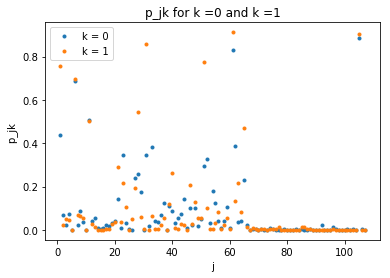

In [51]:
rho_j0 = ML(X_train,Y_train)[0]
rho_j1 = ML(X_train,Y_train)[1]
j = [j for j in range(1,X_train.shape[1]+1)]
plt.plot(j,rho_j0,".")
plt.plot(j,rho_j1,".")
plt.xlabel('j')
plt.ylabel('p_jk ')
plt.title('p_jk for k =0 and k =1')
plt.legend(['k = 0','k = 1'])
plt.show()

**5.**

In [52]:
print ('the number of zero of p_jk where k = 0 is ', len(list(filter(lambda x : x == 0,rho_j0))))
print ('the number of zero of p_jk where k = 1 is ', len(list(filter(lambda x : x == 0,rho_j1))))

the number of zero of p_jk where k = 0 is  15
the number of zero of p_jk where k = 1 is  36


**6.**  
**If $\rho_{jk} = 0$ the likilihood of given data will become zero. it assume that feature $x_j$ will never appear in new data. When you try to predict a new data point which contain the feature $x_j$ with $\rho_{jk}$.The result will always be zero**  
**If $\rho_{jk} =1 $. it assume that the feature $x_j$ will always appear in new data. But truth is new data maybe not has such feature.**

## (3 points) 1B: Naive Bayes: Maximum a Posteriori (m.a.p.)
Let $\rho_{j,k}\sim\text{Beta}(\beta)$, with p.d.f. $f_{\rho_{j,k}}(\rho)=\frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)}$ where $Z$ is a normalisation factor. Assume a uniform prior for $\mu$.
1. Derive the maximum a posteriori $\rho_{j,k}$ and $\mu$ given the above prior.
- Implement a function which computes these maximum a posteriori parameters.
- Verify with ```assert np.allclose()``` that the m.a.p. solution with $\beta=1$ is identical to the m.l. solution. 
- Call your function on ```X_train, Y_train``` with $\beta=10,100,1000$. For each case scatter plot the m.a.p. parameters vs. the m.l. parameters, all on one axis, colored and labelled appropriately.
- Give one example of the role of $\beta$ as evidenced by the plot.

### <span style="color:blue">Answer</span>
**1.**<i>\begin{alignedat}{3}
p(\{\rho_{j,k}\},\mu|\mathcal{D}) &=\frac{p(\mathcal{D}|\{\rho_{j,k}\},\mu)p(\rho_{j,k},\mu)}{p(\mathcal{D})}\
\end{alignedat}</i>

<i>**For given $\mathcal{D}$, $p(\mathcal{D})$ is a constant number**</i>

<i>\begin{alignedat}{3}
p(\{\rho_{j,k}\},\mu|\mathcal{D}) &\propto p(\mathcal{D},|\{\rho_{j,k}\},\mu)p(\{\rho_{j,k}\},\mu)\\
\end{alignedat}</i>
**Beacuse different $\rho_{j,k}$ and $\mu$ are indepent **  
   
<i>\begin{alignedat}{3}
p(\{\rho_{j,k}\},\mu|\mathcal{D}) &\propto p(\mathcal{D},|\{\rho_{j,k}\},\mu)p(\{\rho_{j,k}\},\mu)\\
&\propto p(\mathcal{D},|\{\rho_{j,k}\},\mu)\{\prod_{j=0}^{d}\prod_{k=0}^{1}p(\rho_{j,k})\}p(\mu)\\
&\propto p(\mathcal{D},|\{\rho_{j,k}\},\mu)\{\prod_{j=0}^{d}\prod_{k=0}^{1}f_{\rho_{j,k}}(\rho)\}p(\mu)\\
\end{alignedat}</i>
<i>**Assume $\mu \sim U(a,b)$, $p(\mu) = \frac{1}{a-b}$**</i>
$$p(\{\rho_{j,k}\},\mu|\mathcal{D})\propto p(\mathcal{D},|\{\rho_{j,k}\},\mu)\{\prod_{j=0}^{d}\prod_{k=0}^{1}f_{\rho_{j,k}}(\rho)\}\frac{1}{a-b}$$
**We already derive $p(\mathcal{D}|\{\rho_{j,k}\},\mu)$ in Question 1A so :** 
<i>\begin{alignedat}{3}
p(\{\rho_{j,k}\},\mu|\mathcal{D})
&\propto \{\prod_{i=0}^n\prod_{j=0}^d\prod_{k=0}^1\left[\rho_{j,k}^{x_j^{(i)}}(1-\rho_{j,k})^{1-x_j^{(i)}}\right]^{1(y_i = k)}\}\{\prod_{i=0}^n\mu^{y_i}(1-\mu)^{(1-y_i)}\}\{\prod_{j=0}^{d}\prod_{k=0}^{1}\frac{\rho_{jk}^{\beta-1}(1-\rho_{jk})^{\beta-1}}{{Z(\beta)}}\}\frac{1}{a-b}\\
\end{alignedat}</i>

<i>**Because $Z(\beta)$  and $\frac{1}{a-b}$ are constants**</i>

<i>\begin{alignedat}{3}
p(\{\rho_{j,k}\},\mu|\mathcal{D})
&\propto \{\prod_{i=0}^n\prod_{j=0}^d\prod_{k=0}^1\left[\rho_{j,k}^{x_j^{(i)}}(1-\rho_{j,k})^{1-x_j^{(i)}}\right]^{1(y_i = k)}\}\{\prod_{i=0}^n\mu^{y_i}(1-\mu)^{(1-y_i)}\}\{\prod_{j=0}^{d}\prod_{k=0}^{1}\rho_{jk}^{\beta-1}(1-\rho_{jk})^{\beta-1}\}\\
\ln p(\{\rho_{j,k}\},\mu|\mathcal{D}) 
&\propto \{\sum_{i=0}^n\sum_{j=0}^d\sum_{k=0}^1I(y_i = k)[{x_j^{(i)}}\ln\rho_{j,k}+({1-x_j^{(i)}})\ln(1-\rho_{j,k})]\}\{\sum_{i=0}^n[{y_i}\ln\mu+(1-y_i)\ln(1-\mu)]\}\{\sum_{j=0}^{d}\sum_{k=0}^{1}[(\beta-1)\ln\rho_{jk}+(\beta-1)\ln(1-\rho_{jk})]\}\\
\end{alignedat}</i>  
  
  
**For ${\rho_jk}$**
<i>\begin{alignedat}{3}
\frac{\partial \ln p(\{\rho_{j,k}\},\mu|\mathcal{D})}{\partial \rho_{j,k}}
& =\frac{\partial \{[\sum_{i=0}^n{1(y=k)(x_j^{(i)}}\ln\rho_{j,k}+({1-x_j^{(i)}})\ln(1-\rho_{j,k}))]+ (\beta-1)\ln\rho_{jk}+(\beta-1)\ln(1-\rho_{jk})]\}}{\partial \rho_{j,k}}\\
& = \sum_{i=0}^{n}{x_j^{(i)}\frac{1(y=k)}{\rho_{j,k}}}+({1-x_j^{(i)}})\sum_{i=0}^{n}\frac{1(y=k)}{1-\rho_{j,k}}+\frac{\beta-1}{\rho_{j,k}}+\frac{\beta-1}{1-\rho_{j,k}} =0\\
& = \sum_{i=0}^{n}{\frac{1(y_i=k,x_j^{(i)} = 1)}{\rho_{j,k}}}+\sum_{i=0}^{n}\frac{1(y_i=k,x_j^{(i)} = 0)}{1-\rho_{j,k}}+\frac{\beta-1}{\rho_{j,k}}+\frac{\beta-1}{1-\rho_{j,k}} =0\\
\rho_{j,k} & = \frac{\sum_{i=0}^{n}1(y_i=k,x_j^{(i)} = 1)+\beta-1}{\sum_{i=0}^{n}1(y_i=k,x_j^{(i)} = 0)+\sum_{i=0}^{n}1(y_i=k,x_j^{(i)} = 1)+2\beta-2}
\end{alignedat}</i>
**where $1(.)$ is indicator function**  
  
    
     
       
       
<i>\begin{alignedat}{3}
\rho_{j,k}
&= \frac{count(x_j =1,y = k)+\beta-1}{count(y = k)+2\beta-2}\\
\end{alignedat}</i> 
**where function $count(x)$ compute the number of event x happen**
  
    
    
**For $\mu$**
<i>\begin{alignedat}{3}
\frac{\ln\partial p(\rho_{j,k},\mu|\mathcal{D})}{\partial (\mu)}&=\sum_{i=0}^{n}{y_i\frac{1}{\mu}}+\sum_{i=0}^{n}({1-y_i})\frac{1}{(1-\mu)} = 0\\
\mu & =\frac{\sum_{i=0}^{n}y_i}{n}\\
 \mu& =\frac{count(y = 1)}{n}
\end{alignedat}</i>

**2.**

In [53]:
def MAP(X_train,Y_train,beta):
    num_k1 = np.sum(Y_train) # the number of data which y = 1
    num_k0 = len(Y_train) - num_k1 # the number of data which y = 0
    count_1 = np.sum(X_train[Y_train.reshape(1,-1)[0]==1],axis = 0) # the number of (x_j =1 ,y = 0)
    count_0 = np.sum(X_train[Y_train.reshape(1,-1)[0]==0],axis = 0) # the number of (x_j =1 ,y = 1)
    rho_j1  = (count_1+beta -1)/(num_k1+2*beta-2)
    rho_j0  = (count_0+beta -1)/(num_k0+2*beta-2)
    return rho_j0,rho_j1,num_k1/len(Y_train)

**3.**

In [54]:
#Verify that the m.a.p. solution with  beta = 1 is identical to the m.l. solution.
assert np.allclose(MAP(X_train,Y_train,1)[0],ML(X_train,Y_train)[0])# verify rho_j0
assert np.allclose(MAP(X_train,Y_train,1)[1],ML(X_train,Y_train)[1])# verify rho_j1
assert np.allclose(MAP(X_train,Y_train,1)[2],ML(X_train,Y_train)[2])# verify mu

**4.**

In [55]:
rho_j1_ML = ML(X_train,Y_train)[1]
rho_j1_10_MAP = MAP(X_train,Y_train,10)[1]
rho_j1_100_MAP = MAP(X_train,Y_train,100)[1]
rho_j1_1000_MAP = MAP(X_train,Y_train,1000)[1]

rho_j0_ML = ML(X_train,Y_train)[0]
rho_j0_10_MAP = MAP(X_train,Y_train,10)[0]
rho_j0_100_MAP = MAP(X_train,Y_train,100)[0]
rho_j0_1000_MAP = MAP(X_train,Y_train,1000)[0]

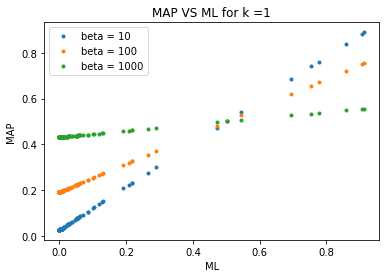

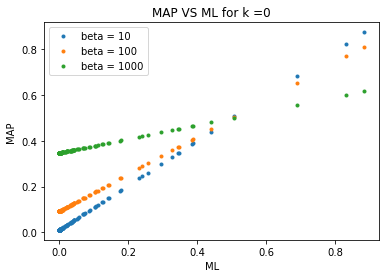

In [56]:
plt.plot(rho_j1_ML,rho_j1_10_MAP,".")
plt.plot(rho_j1_ML,rho_j1_100_MAP,".")
plt.plot(rho_j1_ML,rho_j1_1000_MAP,".")
plt.xlabel('ML')
plt.ylabel('MAP ')
plt.title("MAP VS ML for k =1")
plt.legend(['beta = 10', 'beta = 100','beta = 1000'])
plt.show()

plt.plot(rho_j0_ML,rho_j0_10_MAP,".")
plt.plot(rho_j0_ML,rho_j0_100_MAP,".")
plt.plot(rho_j0_ML,rho_j0_1000_MAP,".")
plt.xlabel('ML')
plt.ylabel('MAP ')
plt.title("MAP VS ML for k =0")
plt.legend(['beta = 10', 'beta = 100','beta = 1000'])
plt.show()

**5.**
**Add $beta$ to model can prevent $\rho_{j,k}$ become zero and the more beta the less relation it holds between ML and MAP**

## (2 points) 1C: Naive Bayes: Prediction
1. Derive the log predictive distribution $\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu)$. Where appropriate, implement this by adding log probabilities instead of multiplying probabilities. Use ```np.logaddexp``` to add probabilities stored in log space.
- Call the above funcion on ```X_test``` using m.a.p. parameters computed with $\beta=2$.
- Plot a histogram of the probabilities (use ```np.exp``` on the log probabilities) using ```plt.hist``` with ```normed=True,histtype='step',label='your_label'```. Do this for the predictive test probabilities corresponding to ```Y_test==1``` and ```Y_test==0```, puting the histograms on the same plot, labeling appropriately.

### <span style="color:blue">Answer</span>
**1.**<i>$$p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu) = \frac{P(\mathbf{x},\{\rho_{j,k}\},\mu|y=1)P(y=1)}{P(\mathbf{x},\{\rho_{j,k}\},\mu)}$$</i>
**because $\mu$ is determine given event $y = 1$**  

<i>\begin{alignedat}{3}
\frac{P(\mathbf{x},\{\rho_{j,k}\},\mu|y=1)P(y=1)}{P(\mathbf{x},\{\rho_{j,k}\},\mu)} &= 
\frac{P(\mathbf{x},\{\rho_{j,1}\}|y=1)\mu}{P(\mathbf{x},\{\rho_{j,k}\},\mu)}\\
& = \frac{\{\prod_{j=1}^{d}{(P(x_j,\{\rho_{j,1}\}|y=1)}\}\mu}{P(\mathbf{x},\{\rho_{j,k}\},\mu)}\\
& = \frac{\prod_{j=1}^{d}\rho_{j,1}^{x_j}(1-\rho_{j,1})^{1-x_j}\mu}{P(\mathbf{x},\{\rho_{j,k}\},\mu)}\\
& = \frac{\prod_{j=1}^{d}\rho_{j,1}^{x_j}(1-\rho_{j,1})^{1-x_j}\mu}{P(\mathbf{x},\{\rho_{j,k}\},\mu|y=1)P(y=1)+P(\mathbf{x},\{\rho_{j,k}\},\mu|y=0)P(y=0)}\\
& = \frac{\prod_{j=1}^{d}\rho_{j,1}^{x_j}(1-\rho_{j,1})^{1-x_j}\mu}
{\prod_{j=1}^{d}\rho_{j,1}^{x_j}(1-\rho_{j,1})^{1-x_j}\mu+\prod_{j=1}^{d}\rho_{j,0}^{x_j}(1-\rho_{j,0})^{1-x_j}(1-\,u)}
\end{alignedat}</i>  

**We note that ${\prod_{j=1}^{d}\rho_{j,1}^{x_j}(1-\rho_{j,1})^{1-x_j}\mu+\prod_{j=1}^{d}\rho_{j,0}^{x_j}(1-\rho_{j,0})^{1-x_j}(1-\,u)}$ as normlization term $N$**
$$\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu) = \sum_{j=1}^{d}{x_j}\log\rho_{j,1}+\sum_{j=1}^{d}{(1-x_j)}\log(1-\rho_{j,1})+\log u - \log N$$
$$\log N = \log((e^{\log \prod_{j=1}^{d}\rho_{j,1}^{x_j}(1-\rho_{j,1})^{1-x_j}\mu})+(e^{\log \prod_{j=1}^{d}\rho_{j,0}^{x_j}(1-\rho_{j,0})^{1-x_j}(1-\mu)}))$$

In [71]:
# this function compute the log predictive distribution 
def predic_dis(X,rho_j0,rho_j1,u,k=1,both = False):
    pd1 = np.log(u)+ X@np.log(rho_j1)+(1-X)@np.log(1-rho_j1) #compute the unnormlized log distribution of P(x|y=1)
    pd0 = np.log(1-u)+ X@np.log(rho_j0)+(1-X)@np.log(1-rho_j0)#compute the unnormlized log distribution of P(x|y=0)
    N =np.logaddexp(pd1,pd0) # computer normlized term N
    if both:
        return pd0-N, pd1-N
    return (pd1 if k==1 else pd0)-N

**2.**

In [72]:
rho_j0,rho_j1,u = MAP(X_train,Y_train,2) #using m.a.p. parameters computed with beta = 2.
log_p_1 = np.exp(predic_dis(X_test,rho_j0,rho_j1,u,k =1)).reshape(-1,1) #log predictive distribution for y = 1
log_p_0 = np.exp(predic_dis(X_test,rho_j0,rho_j1,u,k =0)).reshape(-1,1) #log predictive distribution for y = 0


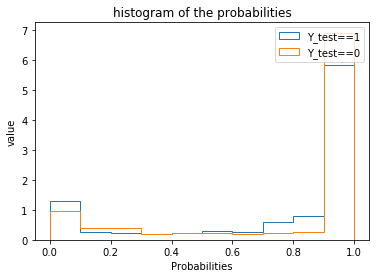

In [73]:
p_1 =log_p_1[Y_test == 1] # predictive test probabilities corresponding to Y_test==1
p_0 =log_p_0[Y_test == 0] # predictive test probabilities corresponding to Y_test==1
plt.hist(p_1,normed= True,histtype= 'step',label= 'Y_test==1')
plt.hist(p_0,normed= True,histtype= 'step',label= 'Y_test==0')
plt.xlabel('Probabilities')
plt.ylabel('value')
plt.title('histogram of the probabilities')
plt.legend(['Y_test==1', 'Y_test==0'])
plt.show()

## (2 points) 1D: Naive Bayes: Evaluation
1. Write a function ```evaluate``` which takes data ```X,Y``` and model parameters $\rho_{j,k}$ and $\mu$, and returns a dict with keys ```mean_logp_true``` (for the mean predictive log probability of the ground truth labels ```Y``` given the data matrix ```X``` and ```percent_correct``` (for the percent correctly classified, assuming we classify each datum into the class with maximum predictive probability).
- Write a function ```cross_validate(beta, nfolds, X, Y)``` which performs cross validation with ```nfolds``` folds, for hyper parameter $\beta$. For each split, call your ```evaluate``` function, and return a ```dict``` with averaged results for each evaluation metric. You can make use of our ```xval_inds``` function.
- For $\beta$ in ```np.logspace(np.log10(2),2,32)``` compute the evaluation metrics on the test set, ```X_test, Y_test```, as well as the cross-validated estimates. Make one plot for each metric, showing both results on each (for a total of four curves). Label appropriately.

In [74]:
def xval_inds(ndata, nfolds):
    # return a list of (trainind, testind) pairs for ndata data points and nfolds xval folds
    assert ndata % nfolds == 0
    nchunk = int(ndata / nfolds)
    itest = [list(range(i*nchunk,(i+1)*nchunk)) for i in range(int(nfolds))]
    itrain = [sorted(set(range(ndata)).difference(set(i))) for i in itest]
    return list(zip(itrain, itest))

### <span style="color:blue">Answer</span>
**1.**

In [75]:

def evalu(X,Y,rho_j0,rho_j1,u):
    pd0,pd1 = predic_dis(X,rho_j0,rho_j1,u,both = True) # predictive log distribution for P(x|y=1) and P(x|y=0)
    p0 = pd0.reshape(-1,1)[Y == 0]# predictive log probabilities corresponding to Y=1
    p1 = pd1.reshape(-1,1)[Y == 1]# predictive log probabilities corresponding to Y=0
    logp_true = np.concatenate((p0, p1), axis=0)
    correct = np.concatenate((np.exp(p0)>0.5, np.exp(p1)>0.5), axis=0)
    return{'mean_logp_ture': np.mean(logp_true), 'percent_correct': np.mean(correct)}   

In [76]:
def cross_validate(beta, nfolds, X, Y):
    cross  = xval_inds(len(Y),nfolds)
    log_t =0
    per_cor= 0
    for echo in range(0,nfolds):
        #print ('echo:',echo,' begin')
        X_train =X[cross[echo][0],:] #train set
        Y_train =Y[cross[echo][0]]   #trian label
        X_test =X[cross[echo][1],:]  #test set
        Y_test =Y[cross[echo][1]]    #test label
        rho_j0,rho_j1,u = MAP(X_train,Y_train,beta)
        re = evalu(X_test,Y_test,rho_j0,rho_j1,u)
        log_t += re['mean_logp_ture']
        per_cor += re['percent_correct']
    return {'mean_logp_ture':log_t/nfolds,'percent_correct': per_cor/nfolds}


In [77]:
eval_mean_log_t =[]
eval_per_cor =[]
cros_mean_log_t=[]
cros_per_cor =[]
Beta = np.logspace(np.log10(2),2,32)
for beta in Beta:
    rho_j0,rho_j1,u = MAP(X_train,Y_train,beta)
    eva = evalu(X_test,Y_test,rho_j0,rho_j1,u)
    cro = cross_validate(beta, 11, X_test, Y_test)
    cros_mean_log_t.append(cro['mean_logp_ture'])
    cros_per_cor.append(cro['percent_correct'])
    eval_mean_log_t.append(eva['mean_logp_ture'])
    eval_per_cor.append(eva['percent_correct'])
    

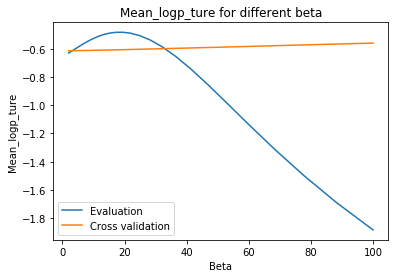

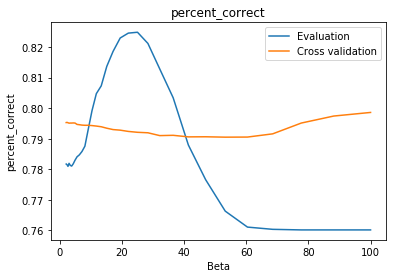

In [78]:
plt.plot(Beta,eval_mean_log_t)
plt.plot(Beta,cros_mean_log_t)
plt.xlabel('Beta')
plt.ylabel('Mean_logp_ture')
plt.title('Mean_logp_ture for different beta')
plt.legend(['Evaluation', 'Cross validation'])
plt.show()
plt.plot(Beta,eval_per_cor)
plt.plot(Beta,cros_per_cor)
plt.xlabel('Beta')
plt.ylabel('percent_correct')
plt.title('percent_correct')
plt.legend(['Evaluation', 'Cross validation'])
plt.show()


## (2 points) 1E: Naive Bayes: Discussion
1. Explain the shortcomings of our preprocessing of (a) continous variables, and (b) categorical variables. Make note of the assumptions of our model.
- Suggest improvements to our data processing pipeline, both in terms of the representation and the model.
- Consider the distribution $p(a,b,c)$ where all three variables are binary. How many parameters are needed to specify this distribution (a) in general and (b) if it factorises as $p(a|c)p(b|c)p(c)$?

### <span style="color:blue">Answer</span>

1. (a) The shortcoming of preprocessing the continous variables by using median splits is unreasonalble. By applying this kind of preprcessing, it assume that split people(data) into two group, but in many case median is not a good point to split. a lot of information will be neglected. (b) The shortcoming of preprocessing the categorical variables by converting it into indicator vector is that it will increase the dimension of the feature. The feature space can really blow up quickly and become sparse when you need to convert many categories.This will result in curse of dimensionality.Plus It will need more training data.  
As for assumptions of Navie Bayes Model, it assume the feature are independent of each other in the really word. If there are some causal relation among features. The feature space should be more compact 

2. 
For continous variables we can apply mean split.Use mean of feature vector as the split point. 
For categorical variables we can still convert it into indicator vector. After do that we can use Principal components analysis(PCA) for dimensionality reduction to prevent curse of dimensionality

3. (a)For the distribution $p(a,b,c)$ there are 3 boolean variables. If we have a parameter for every possible the variables, there will be $2^{3}$ parameters. But we know that the $2^3$ parameter need to sum to one. the last parameter can be compute by the others. So we only need $2^{3}-1 $parameters (b) For $p(a|c)p(b|c)p(c)$,there are 5 parameters in need. They are
$p(a=1|c=0),p(a=1|c=1),p(b=1|c =0),p(b=1|c = 1),p(c=1)$


## (3 points) 2A: Representation Proof
Consider a parametric model governed by the parameter vector $\mathbf{w}$ together with a dataset of input values $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and a nonlinear feature mapping $\phi(\mathbf{x})$. Suppose that the dependence of the error function on $\mathbf{w}$ takes the form $J(\mathbf{w}) = f(\mathbf{w}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}^\top \phi(\mathbf{x}_N)) + g(\mathbf{w}^\top \mathbf{w})$
where $g(\cdot)$ is a monotonically increasing function. By writing $\mathbf{w}$ in the form
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp
$$
show that the value of $\mathbf{w}$ that minimizes $J(\mathbf{w})$ takes the form of a linear combination of the basis functions $\phi(\mathbf{x}_n)$ for $n = 1, \ldots, N$.

### <span style="color:blue">Answer</span>
<i>**Consider this error function**
$$J(\mathbf{w}) = f(\mathbf{w}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}^\top \phi(\mathbf{x}_N)) + g(\mathbf{w}^\top \mathbf{w}))$$  

**where $\mathbf{w} = (w_0, w_1, w_2, \dots, w_{M_1})$ , and $\phi(\mathbf{x})^T =(\phi_0(\mathbf{x}),\phi_1(\mathbf{x}),\phi_2(\mathbf{x},\dots,\phi_{M-1}(\mathbf{x}))^T$**  
  
    
    

<i>**We could also write this in more compact form as**</i>
$$J(\mathbf{w}) = f(\mathbf{w}^T \Phi)+g(\mathbf{w}^\top \mathbf{w})$$
<i>**where $\Phi$ is**</i>:
$$
 \Phi = \left[
 \begin{matrix}
   \phi(x_1) \\
   \phi(x_2) \\
   \phi(x_3) \\
   \dots\\
   \phi(x_N)
  \end{matrix}
  \right]
$$
<i>\begin{alignedat}{3}
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}& = f^{'}(\mathbf{w}^T \Phi)\Phi+2g^{'}(\mathbf{w}^T\mathbf{w})\mathbf{w}&\\
\end{alignedat}
**Try to find $\mathbf{w}$ that minimizes $J(\mathbf{w})$ which makes$\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}=0$**
<i>\begin{alignedat}{3}
 -2g^{'}(\mathbf{w}^T\mathbf{w})\mathbf{w} &=f^{'}(\mathbf{w}^T \Phi)\Phi\\
\end{alignedat}</i>
<i>**$g(\cdot)$ is a monotonically increasing function so $g^{'}(\mathbf{w}^T\mathbf{w})>0$**</i>
\begin{alignedat}{3}
\mathbf{w} &=\frac{f^{'}(\mathbf{w}^T \Phi)\Phi}{-2g^{'}(\mathbf{w}^T\mathbf{w})}\\
\mathbf{w} &=\Phi \mathbf{a}\\
& = \sum_{i=1}^N a_n\phi(x_n)
\end{alignedat}
<i> **where $\mathbf{a} = (a_1,a_2,\dots,a_N)^T$ with components**</i>
$$a_n = -\frac{f^{'}(\mathbf{w}^T \phi_n)}{2g^{'}(\mathbf{w}^T\mathbf{w})}$$



## (2 points) Maximum likelihood (ML) and Maximum A Posteriori (MAP)
We assume data samples $X_n = \{ x_1,\dots,x_n \}$ are generated i.i.d. from a uniform distribution
$ \DUniform{x}{0}{\theta} $ between $ 0 $ and an unknown positive parameter $\theta$:
$$
   p(x \Cond \theta) = \DUniform{x}{0}{\theta} = 
\begin{cases}
 1/\theta & 0 \leq x \leq \theta \\
 0        & \textrm{otherwise} \\
\end{cases}
$$

Assume the data samples $ X_4 = \{ 5, 7, 3, 9 \}$ have been observed.

1. Calculate $\theta_{ML} = \argmax_{\theta} p(X_4 \Cond \theta)$, 
the maximum likelihood estimate of $\theta$ for the observed data.

- Calculate $p(\theta \Cond X_4)$, the posterior distribution of $\theta$ given that the 
data $ X_4 $ have been observed and 
the initial distribution for $\theta$ is given as $p(\theta) = p(\theta \Cond X_0) = \DUniform{x}{0}{10}$.

- Calculate $\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4)$, the maximum a posteriori
estimate of $\theta$ given the data $ X_4 $ and the initial distribution $p(\theta)$ as in the previous question.

- Calculate $\theta_{ML}$, $p(\theta \Cond X_4)$, and $\theta_{MAP}$ for the case that the observed data are $ X_4 = \{ 9, 5, 7, 3 \}$ instead of the $ X_4 = \{ 5, 7, 3, 9 \}$ given above.

### <span style="color:blue">Answer</span>
<i>**1.  
Because$X_n = \{ x_1,\dots,x_n \}$ are generated i.i.d, the likelihood function can write in such form
$$p(X_4 \Cond \theta) = \prod_{i=1}^{4}p(x_i \Cond \theta)=\prod_{i=0}^{4}\DUniform{x_i}{0}{\theta}$$
We observed that if $\theta < Max(\{ x_1,\dots,x_n \})$,one or more of $\DUniform{x_i}{0}{\theta} = 0$,so the likelihood function equals $0$  
the likelihood function can be writen in this form:
\begin{equation}
p(X_4 \Cond \theta)=
\left\{
\begin{array}{rl}
&0, \theta < 9\\
&\frac{1}{\theta^4}, \theta >= 9\\
\end{array}
\right.
\end{equation}
because $\frac{1}{\theta^4}$ is a monotonically decreasing function and get the maximum value at $\theta = 9$
so : 
$$\theta_{ML} = \argmax_{\theta} p(X_4 \Cond \theta) = 9$$
**</i>
**2.**
\begin{alignedat}{3}
p(\theta |\{5\}) &= \frac{p(\{5\}|\theta)p(\theta)}{\int_0^{10}p(\{5\}|\theta)p(\theta)d\theta} 
                  = \frac{p(\{5\}|\theta)p(\theta)}{\int_0^{5}p(\{5\}|\theta)p(\theta)d\theta + \int_5^{10}p(\{5\}|\theta)d\theta}=
\begin{equation}
\left\{
\begin{array}{rl}
&0, else\\
&(\theta \int_5^{10}\theta^{-1} d\theta)^{-1}, 5\leq\theta\leq 10\\
\end{array}
\right.
\end{equation}\\
\end{alignedat}

\begin{alignedat}{3}
p(\theta |\{5,7\}) &= \frac{p(\{7\}|\theta)p(\theta |\{5\})}{\int_0^{10}p(\{7\}|\theta)p(\theta |\{5\})d\theta} =
\begin{equation}
\left\{
\begin{array}{rl}
&0, else\\
&\left(\theta^{2}\int_7^{10}\theta^{-2} d\theta \right)^{-1}, 7\leq\theta \leq10\\
\end{array}
\right.
\end{equation}\\
\end{alignedat}

\begin{alignedat}{3}
p(\theta |\{5,7,3\}) &= \frac{p(\{3\}|\theta)p(\theta |\{5,7\})}{\int_0^{10}p(\{3\}|\theta)p(\theta |\{5,7\})d\theta} =
\begin{equation}
\left\{
\begin{array}{rl}
&0, else\\
&\left(\theta^{3}\int_7^{10}\theta^{-3} d\theta \right)^{-1}, 7\leq\theta\leq10\\
\end{array}
\right.
\end{equation}\\
\end{alignedat}

\begin{alignedat}{3}
p(\theta|X_4)=p(\theta |\{5,7,3,9\}) &= \frac{p(\{9\}|\theta)p(\theta |\{5,7,3\})}{\int_0^{10}p(\{9\}|\theta)p(\theta |\{5,7,3\})d\theta} =
\begin{equation}
\left\{
\begin{array}{rl}
&0, else\\
&\left(\theta^{4}\int_9^{10}\theta^{-4} d\theta \right)^{-1}, 9\leq\theta\leq 10\\
\end{array}
\right.
\end{equation}\\
\end{alignedat}



**3. 
Because $p(\theta|X_4)$ is a monotonically decreasing function and get the maximum value at $\theta = 9$
so : **  

$$\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4) = 9$$

**4.The value remains same regardless the order so **
\begin{alignedat}{3}
\theta_{ML} & = 9\\
\theta_{MAP} & = 9\\
p(\theta|X_4) &=
\begin{equation}
\left\{
\begin{array}{rl}
&0, else\\
&\left(\theta^{4}\int_9^{10}\theta^{-4} d\theta \right)^{-1}, 9 \leq\theta \leq 10\\
\end{array}
\right.
\end{equation}\\
\end{alignedat}

## (2 points) Laplace Approximation
The function
$$
  f(z) = z^k e^{-z^2/2} \qquad \qquad z \in [0, \infty), \qquad k > 0
$$
can be considered as an (unnormalised) probability density.

1. Verify that it is possible to approximate $ f(z) $ with the Laplace Approximation.

- Using the Laplace Approximation, find the mean and the variance of the Normal Distribution which best approximates the normalised version of $ f(z) $.

- The analytical form of the normalisation of $ f(x) $ is not so easy to find. Therefore, use Python to implement a numerical approximation using $ N = 100 $ identically sized intervals between $ 0 $ and $ a = 10 $ to calculate the normalisation 
$$
  \int_0^{\infty} f(z) \mathrm{d}z 
  \approx \int_0^{a} z^k e^{-z^2/2} \mathrm{d}z 
  \approx \sum_{i=1}^{100} \dots
$$
and report the results for the normalisation with a 
precision of $5$ digits after the comma for the three cases $ k = \{0.5, 3, 5 \}$.
            
- For each of the three cases $ k = \{0.5, 3, 5 \}$, plot the normalised function $ f(z) $
and the corresponding Normal Distribution with parameters  resulting from the Laplace Approximation.

- Why is it reasonable to replace the upper limit of $ \infty$ with $ a = 10 $ ?

### <span style="color:blue">Answer</span>


**1.** 
\begin{alignedat}{3}
lnf(z)&=klnz+(-\frac{z^2}{2})\\
\frac{d({lnf(z)})}{d{z}}& = \frac{k}{z}-z =0\\
z^2&=k
\end{alignedat}
**where $z>0$ so $z_0 = \sqrt{k}$**
\begin{alignedat}{3}
\frac{d^2({lnf(z)})}{d^2{z}}& = -\frac{k}{z^2}-1\\
& = -(\frac{k}{z^2}+1)<0\\
\end{alignedat}
** So it is possible to approximate  $f(z)$  with the Laplace Approximation.
**

**2.**  
**We consider $A=-\frac{d^2({lnf(z)})}{d^2{z}}\Cond_{z=z_0} =\frac{k}{z_0^2}+1 =2$**  
**Taylor expansion of $ln f(z)$ at $z_0$**
\begin{alignedat}{3}
lnf(z)&\backsimeq lnf(z_0)-\frac{A}{2}(z-z_0)^2\\
f(z)&\backsimeq f(z_0)e^{-\frac{A}{2}(z-z_0)^2}
\end{alignedat}
**if we note the normalised version of $f(z)$ as $q(z)$**
$$q(z) = (\frac{A}{2\pi})^{\frac{1}{2}}e^{-\frac{A}{2}(z-z_0)^2}$$
$$q(z) = (\frac{1}{\pi})^{\frac{1}{2}}e^{-(z-\sqrt{k})^2}$$
$$Mean = \sqrt{k}$$
$$Var = \frac{1}{2}$$

**3.**

In [79]:
def Num_approx(a,N,k):
    deta_x = a/N
    v = np.linspace(0, a, num=N)
    y = list(map(lambda z: (z**k) * np.exp(-z**2/2),v))
    result = sum(list(map(lambda x:x * deta_x, y)))
    return result
print(Num_approx(10, 100, 0.5))
print(Num_approx(10, 100, 3))
print(Num_approx(10, 100, 5))

1.01353558704
1.98000086093
7.9199999958


** The normalisation for $k = 0.5$ is $1.01353$**  
** The normalisation for $k = 3$ is $1.98000$**  
** The normalisation for $k = 0.5$ is $7.92000$**

**4.**

In [80]:
def f_norm(z,k):
    return np.array(list(map(lambda x: (x**k)*math.exp(-x**2/2),z)))/Num_approx(10,100,k)
def Lap_approx(z,k):
    return np.array(list(map(lambda x: math.sqrt((1/math.pi))*math.exp(-(x-math.sqrt(k))**2), z)))


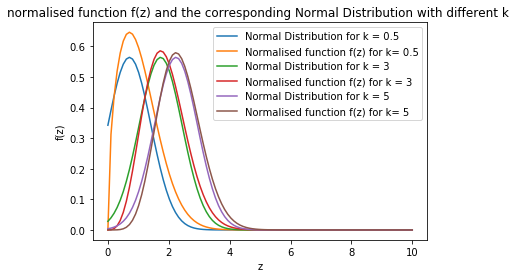

In [81]:
x= np.linspace(0, 10, num=100)
y_norm_05 = f_norm(x,0.5)
y_Lap_05 = Lap_approx(x,0.5)
y_norm_3 = f_norm(x,3)
y_Lap_3 = Lap_approx(x,3)
y_norm_5 = f_norm(x,5)
y_Lap_5 = Lap_approx(x,5)
plt.plot(x,y_Lap_05)
plt.plot(x,y_norm_05)
plt.plot(x,y_Lap_3)
plt.plot(x,y_norm_3)
plt.plot(x,y_Lap_5)
plt.plot(x,y_norm_5)
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('normalised function f(z) and the corresponding Normal Distribution with different k ')
plt.legend(['Normal Distribution for k = 0.5', 'Normalised function f(z) for k= 0.5',
           'Normal Distribution for k = 3', 'Normalised function f(z) for k = 3',
           'Normal Distribution for k = 5', 'Normalised function f(z) for k= 5'])
plt.show()

**5.**

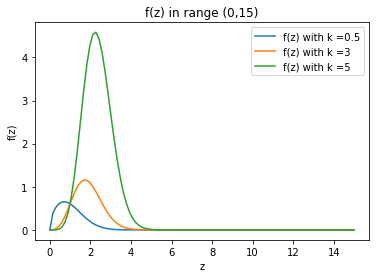

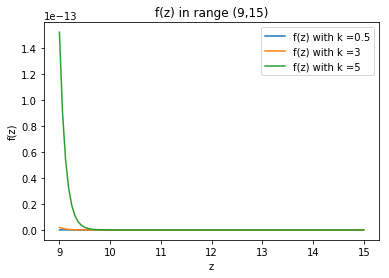

In [82]:
z = np.linspace(0, 15, num=100)
f_z_05 = list(map(lambda z:(z**0.5)*math.exp(-z**2/2),z))
f_z_3 = list(map(lambda z:(z**3)*math.exp(-z**2/2),z))
f_z_5 = list(map(lambda z:(z**5)*math.exp(-z**2/2),z))
plt.plot(z,f_z_05)
plt.plot(z,f_z_3)
plt.plot(z,f_z_5)
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('f(z) in range (0,15)')
plt.legend(['f(z) with k =0.5','f(z) with k =3','f(z) with k =5'])
plt.show()
z = np.linspace(9, 15, num=100)
f_z_05 = list(map(lambda z:(z**0.5)*math.exp(-z**2/2),z))
f_z_3 = list(map(lambda z:(z**3)*math.exp(-z**2/2),z))
f_z_5 = list(map(lambda z:(z**5)*math.exp(-z**2/2),z))
plt.plot(z,f_z_05)
plt.plot(z,f_z_3)
plt.plot(z,f_z_5)
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('f(z) in range (9,15)')
plt.legend(['f(z) with k =0.5','f(z) with k =3','f(z) with k =5'])
plt.show()


**I plot the $f(z)$ with $k = 0.5 ,3 ,5$ respectively with in range$(0,15)$ and range $(9,15)$, we can see from the pitcture, when $z > 10$, $f(z)\approx 0$  
$$\int_0^{\infty} f(z) \mathrm{d}z = \int_0^{a} f(z) \mathrm{d}z + \int_a^{\infty} f(z) \mathrm{d}z$$  
When $z > 10$, $f(z)\approx 0$, so $\int_a^{\infty} f(z) \mathrm{d}z \approx 0$  
$$  \int_0^{\infty} f(z) \mathrm{d}z 
  \approx \int_0^{a} z^k e^{-z^2/2} \mathrm{d}z $$**